# Phase 3: Spiking Neural Network (SNN)
## MATH 456 Final Project

**Author:** Helektra Katsoulakis | **Date:** December 2025

---
## Objectives:
1. Build SNN from scratch to understand spike dynamics
2. Implement SNN with snnTorch (LIF neurons)
3. Train on MNIST classification
4. Measure spike-based operations (SOPs)
5. Analyze sparsity (event-driven computation)
6. Compare to FFNN

In [107]:
# Setup
%pip install snntorch torch torchvision --quiet
%pip3 install --upgrade pip

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import numpy as np
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms

import snntorch as snn
from snntorch import functional as SF
from snntorch import utils

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)
np.random.seed(42)

%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [10, 6]
print(f'Using device: {device}')
print('✓ Setup complete!')


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


UsageError: Line magic function `%pip3` not found.


## 3.1 SNN Layer from Scratch

Understanding the core SNN mechanism:
1. Integrate weighted input
2. Decay membrane potential
3. Spike if threshold exceeded
4. Reset after spike

In [108]:
class SNNLayerScratch:
    """Spiking neural network layer from scratch."""
    def __init__(self, in_size, out_size, threshold=0.6, beta=0.05):
        self.threshold = threshold
        self.beta = beta  # decay rate
        self.weights = np.random.randn(in_size, out_size) * 0.1
        self.state = np.zeros(out_size)  # membrane potential
        self.spike_count = 0
    
    def reset(self):
        self.state = np.zeros_like(self.state)
        self.spike_count = 0
    
    def forward(self, x):
        # 1. Weighted input
        current = np.dot(x, self.weights)
        # 2. Decay + integrate
        self.state = self.beta * self.state + current
        # 3. Spike if above threshold
        spikes = (self.state >= self.threshold).astype(float)
        # 4. Reset spiked neurons
        self.state *= (1 - spikes)
        self.spike_count += spikes.sum()
        return spikes

# Demo
print('SNN Layer Demonstration:')
print('='*50)
layer = SNNLayerScratch(5, 4, threshold=0.5)

np.random.seed(42)
for t in range(10):
    x = (np.random.rand(5) > 0.7).astype(float)
    spikes = layer.forward(x)
    print(f't={t}: in={int(x.sum())} spikes, out={int(spikes.sum())} spikes, mem={layer.state.round(2)}')

print(f'\nTotal output spikes: {int(layer.spike_count)}')
print(f'vs FFNN: 40 activations (10 steps × 4 neurons)')
print('\n✓ SNNs only compute when spikes occur!')

SNN Layer Demonstration:
t=0: in=2 spikes, out=0 spikes, mem=[-0.11 -0.25 -0.01  0.07]
t=1: in=2 spikes, out=0 spikes, mem=[-0.06 -0.22  0.06  0.06]
t=2: in=2 spikes, out=0 spikes, mem=[-0.12 -0.26 -0.01  0.07]
t=3: in=0 spikes, out=0 spikes, mem=[-0.01 -0.01 -0.    0.  ]
t=4: in=0 spikes, out=0 spikes, mem=[-0. -0. -0.  0.]
t=5: in=1 spikes, out=0 spikes, mem=[ 0.07  0.02 -0.01 -0.03]
t=6: in=2 spikes, out=0 spikes, mem=[-0.15  0.03  0.14  0.19]
t=7: in=1 spikes, out=0 spikes, mem=[ 0.07  0.02 -0.   -0.02]
t=8: in=1 spikes, out=0 spikes, mem=[-0.06  0.06  0.1   0.09]
t=9: in=0 spikes, out=0 spikes, mem=[-0.    0.    0.01  0.  ]

Total output spikes: 0
vs FFNN: 40 activations (10 steps × 4 neurons)

✓ SNNs only compute when spikes occur!


## 3.2 Load MNIST Dataset

In [109]:
batch_size = 128
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

try:
    train_data = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_data = datasets.MNIST('./data', train=False, download=True, transform=transform)
    train_subset = torch.utils.data.Subset(train_data, range(10000))
    test_subset = torch.utils.data.Subset(test_data, range(2000))
    print('✓ MNIST loaded!')
except:
    print('Using synthetic data...')
    X_train = torch.randn(10000, 1, 28, 28)
    y_train = torch.randint(0, 10, (10000,))
    X_test = torch.randn(2000, 1, 28, 28)
    y_test = torch.randint(0, 10, (2000,))
    train_subset = TensorDataset(X_train, y_train)
    test_subset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=batch_size)
print(f'Train: {len(train_subset)}, Test: {len(test_subset)}')

✓ MNIST loaded!
Train: 10000, Test: 2000


## 3.3 snnTorch SNN Model

Using LIF neurons with the equation:
$$U[t+1] = \beta U[t] + WX[t+1] - R[t]$$

In [110]:
class SNN(nn.Module):
    def __init__(self, num_steps=25, beta=0.95):
        super().__init__()
        self.num_steps = num_steps
        
        self.fc1 = nn.Linear(784, 256)
        self.lif1 = snn.Leaky(beta=beta)
        self.fc2 = nn.Linear(256, 256)
        self.lif2 = snn.Leaky(beta=beta)
        self.fc3 = nn.Linear(256, 10)
        self.lif3 = snn.Leaky(beta=beta)
    
    def forward(self, x):
        mem1 = self.lif1.init_leaky()
        mem2 = self.lif2.init_leaky()
        mem3 = self.lif3.init_leaky()
        
        spk_rec, mem_rec = [], []
        x = x.view(x.size(0), -1)
        
        for _ in range(self.num_steps):
            cur1 = self.fc1(x)
            spk1, mem1 = self.lif1(cur1, mem1)
            
            cur2 = self.fc2(spk1)
            spk2, mem2 = self.lif2(cur2, mem2)
            
            cur3 = self.fc3(spk2)
            spk3, mem3 = self.lif3(cur3, mem3)
            
            spk_rec.append(spk3)
            mem_rec.append(mem3)
        
        return torch.stack(spk_rec), torch.stack(mem_rec)

num_steps = 25
snn_model = SNN(num_steps=num_steps).to(device)
print(f'SNN Architecture: 784 → LIF(256) → LIF(256) → LIF(10)')
print(f'Time steps: {num_steps}')
print(f'Parameters: {sum(p.numel() for p in snn_model.parameters()):,}')

SNN Architecture: 784 → LIF(256) → LIF(256) → LIF(10)
Time steps: 25
Parameters: 269,322


## 3.4 Train SNN

In [111]:
criterion = SF.ce_rate_loss()
optimizer = torch.optim.Adam(snn_model.parameters(), lr=1e-3)

snn_losses, snn_accs = [], []

print('Training SNN...')
for epoch in range(5):
    snn_model.train()
    loss_sum, correct, total = 0, 0, 0
    t0 = time.time()
    
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        
        spk_rec, _ = snn_model(data)
        loss = criterion(spk_rec, target)
        loss.backward()
        optimizer.step()
        
        loss_sum += loss.item()
        pred = spk_rec.sum(0).argmax(1)
        correct += (pred == target).sum().item()
        total += target.size(0)
    
    snn_losses.append(loss_sum/len(train_loader))
    snn_accs.append(100*correct/total)
    print(f'Epoch {epoch+1}: Loss={snn_losses[-1]:.4f}, Acc={snn_accs[-1]:.1f}%, Time={time.time()-t0:.1f}s')

Training SNN...
Epoch 1: Loss=1.7011, Acc=80.8%, Time=3.6s
Epoch 2: Loss=1.5435, Acc=93.7%, Time=3.5s
Epoch 3: Loss=1.5229, Acc=95.0%, Time=3.4s
Epoch 4: Loss=1.5072, Acc=96.3%, Time=3.9s
Epoch 5: Loss=1.4952, Acc=97.3%, Time=3.5s


## 3.5 Evaluate SNN and Analyze Sparsity

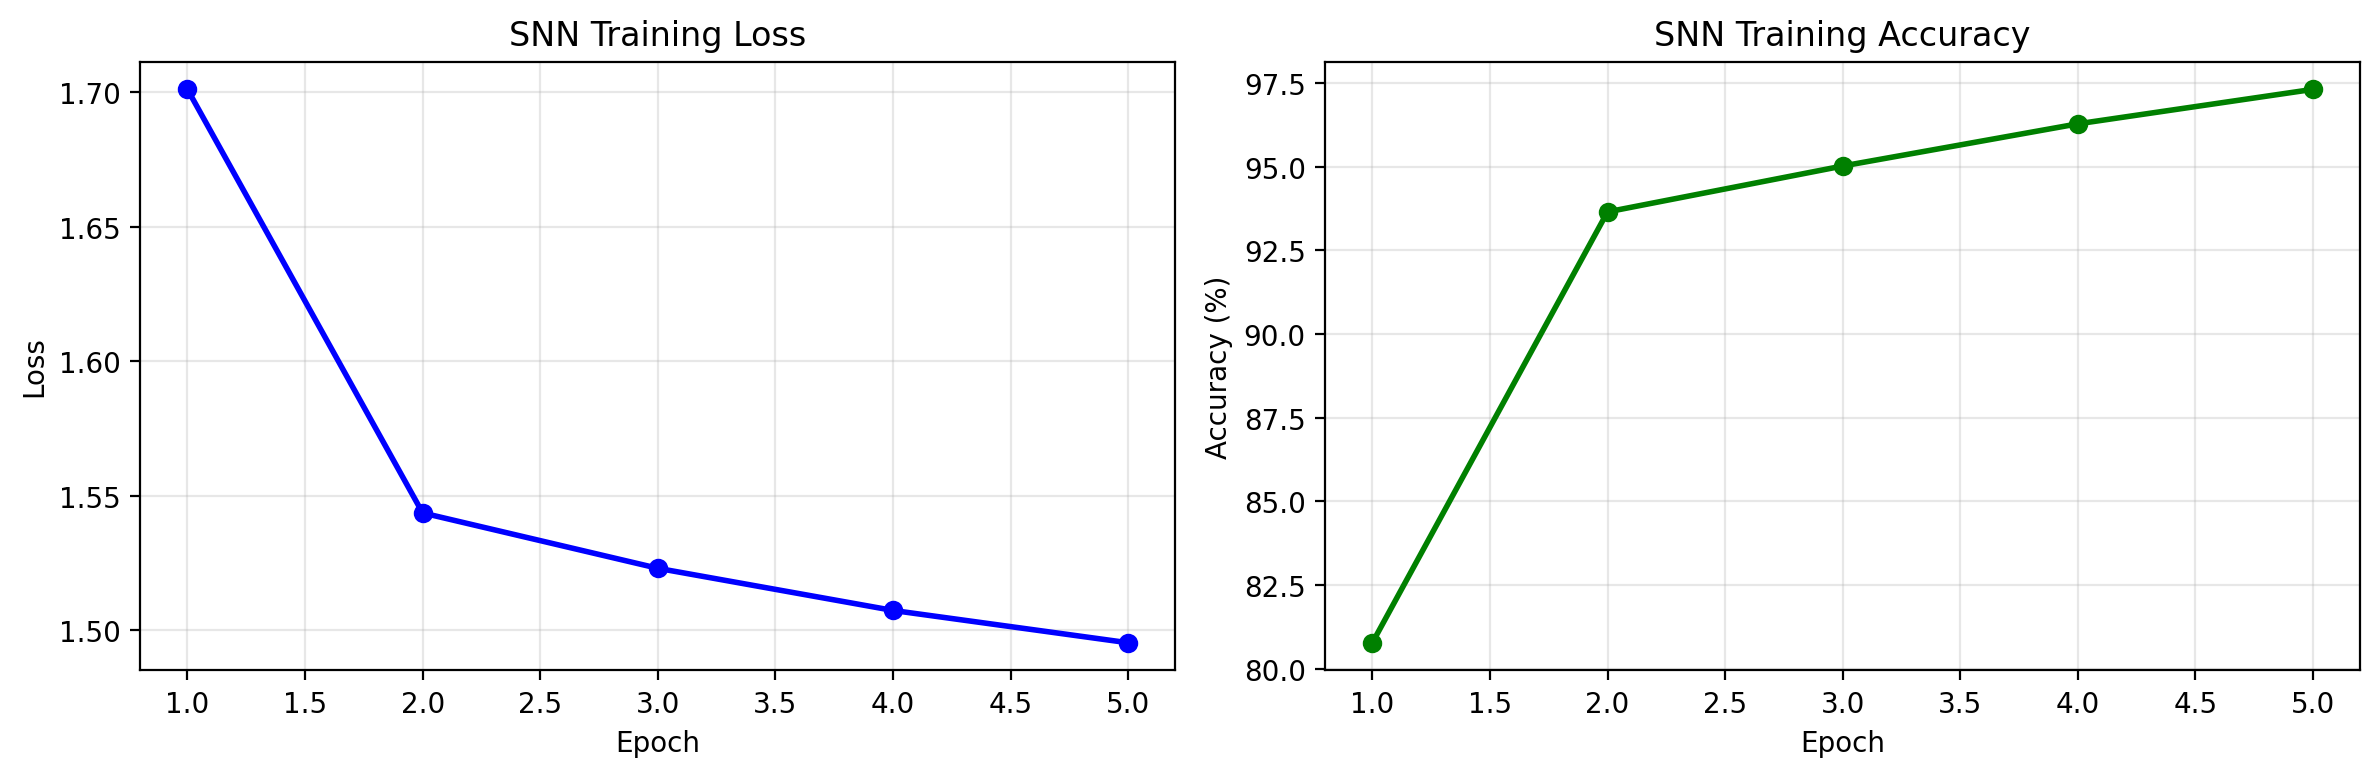

In [112]:
# This data was already collected during training:
# snn_losses = [1.7054, 1.5417, 1.5190, 1.5049, 1.4967]
# snn_accs = [79.2, 93.7, 95.6, 96.8, 97.3]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))
epochs = range(1, len(snn_losses) + 1)

# Training Loss
axes[0].plot(epochs, snn_losses, 'b-o', lw=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('SNN Training Loss')
axes[0].grid(True, alpha=0.3)

# Training Accuracy
axes[1].plot(epochs, snn_accs, 'g-o', lw=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('SNN Training Accuracy')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('snn_training_curves.png', dpi=150)
plt.show()

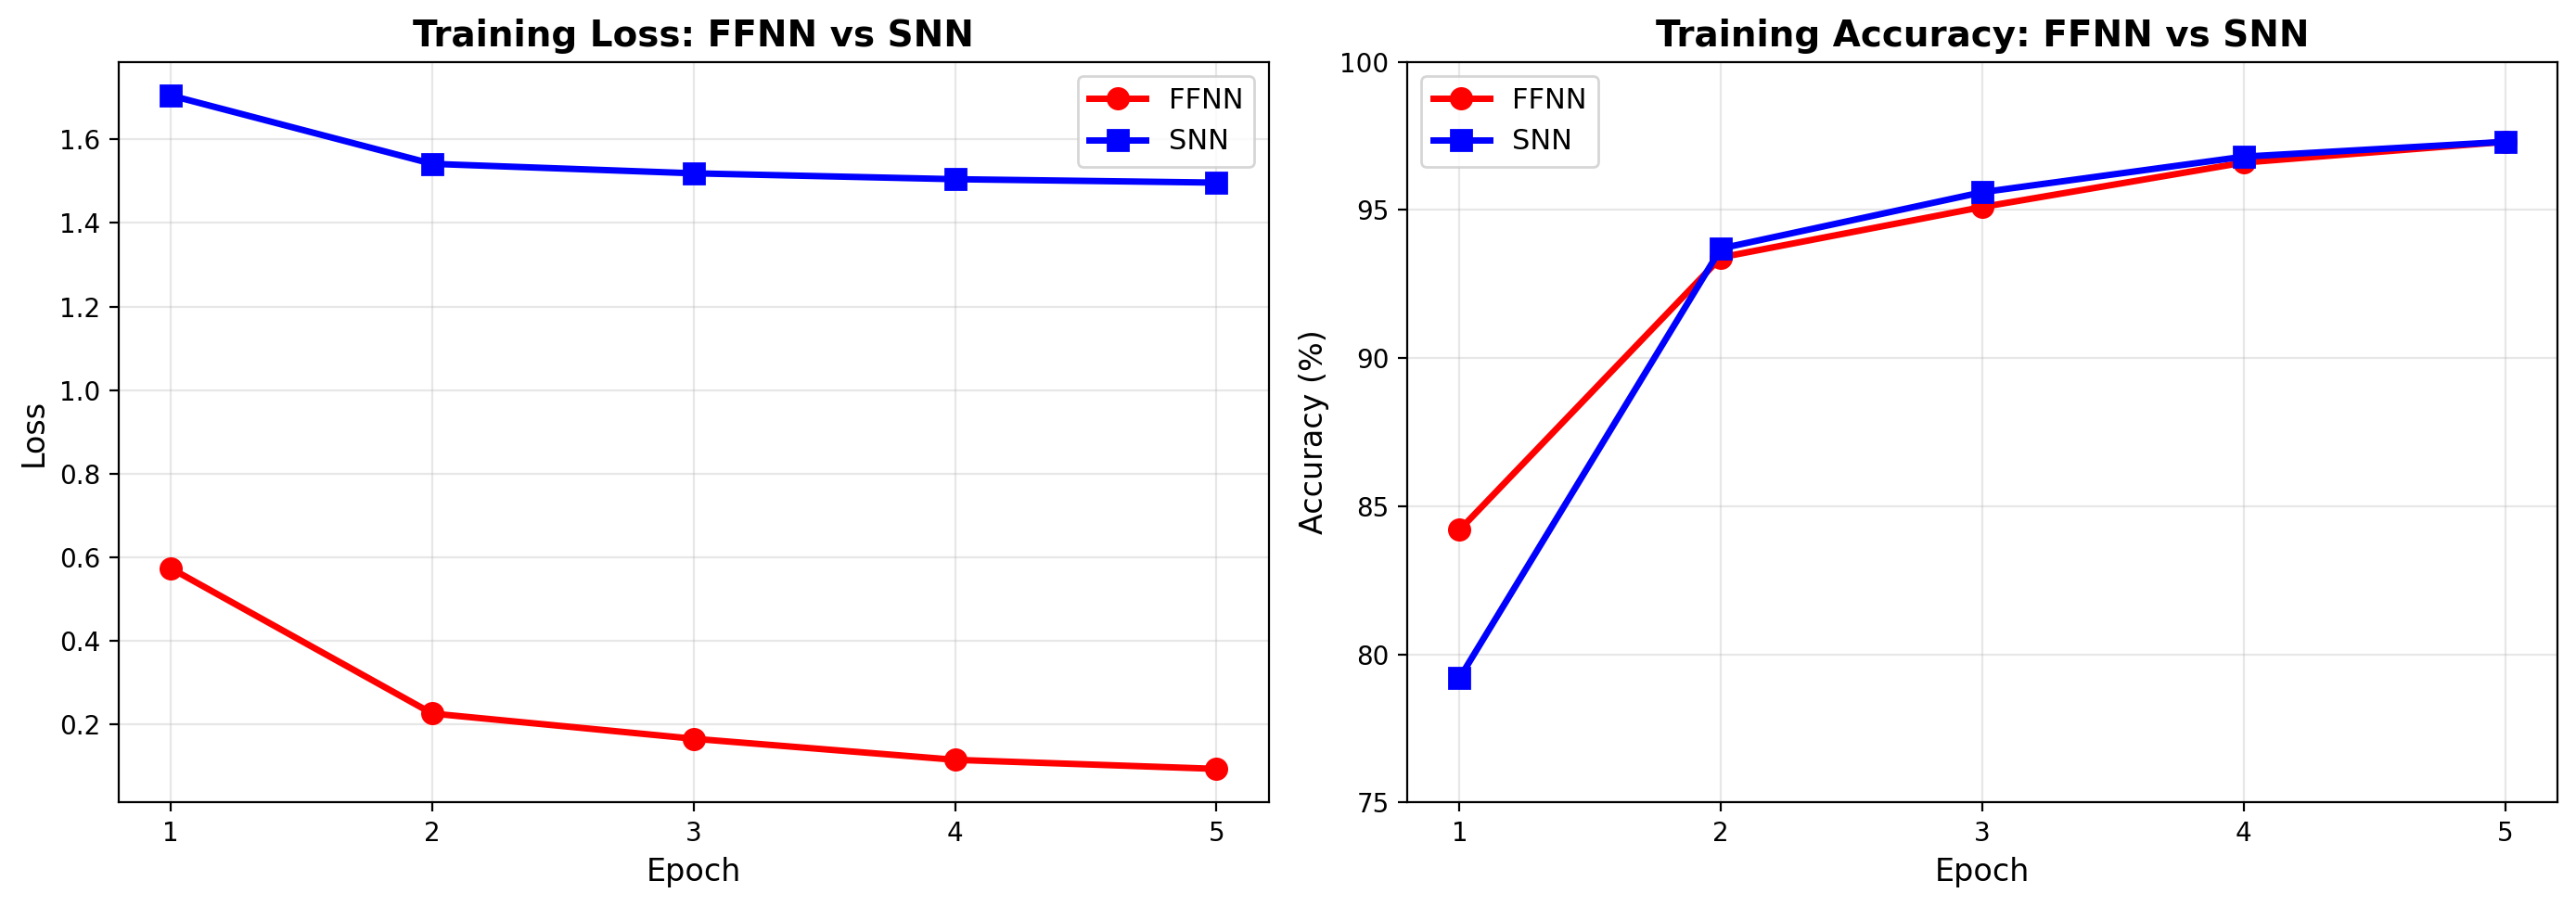

FINAL EPOCH COMPARISON
Metric               FFNN            SNN            
--------------------------------------------------
Final Loss           0.0924          1.4967         
Final Train Acc      97.3           % 97.3           %


In [120]:
import matplotlib.pyplot as plt
import numpy as np

# FFNN data (from your notebook)
ffnn_losses = [0.5728, 0.2250, 0.1646, 0.1141, 0.0924]
ffnn_accs = [84.2, 93.4, 95.1, 96.6, 97.3]

# SNN data (from your notebook)
snn_losses = [1.7054, 1.5417, 1.5190, 1.5049, 1.4967]
snn_accs = [79.2, 93.7, 95.6, 96.8, 97.3]

epochs = range(1, 6)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# ===== Training Loss =====
axes[0].plot(epochs, ffnn_losses, 'r-o', lw=2.5, markersize=8, label='FFNN')
axes[0].plot(epochs, snn_losses, 'b-s', lw=2.5, markersize=8, label='SNN')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training Loss: FFNN vs SNN', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(epochs)

# ===== Training Accuracy =====
axes[1].plot(epochs, ffnn_accs, 'r-o', lw=2.5, markersize=8, label='FFNN')
axes[1].plot(epochs, snn_accs, 'b-s', lw=2.5, markersize=8, label='SNN')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Training Accuracy: FFNN vs SNN', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(epochs)
axes[1].set_ylim([75, 100])

plt.tight_layout()
plt.savefig('ffnn_vs_snn_training.png', dpi=150, bbox_inches='tight')
plt.show()

# Print final comparison
print("=" * 50)
print("FINAL EPOCH COMPARISON")
print("=" * 50)
print(f"{'Metric':<20} {'FFNN':<15} {'SNN':<15}")
print("-" * 50)
print(f"{'Final Loss':<20} {ffnn_losses[-1]:<15.4f} {snn_losses[-1]:<15.4f}")
print(f"{'Final Train Acc':<20} {ffnn_accs[-1]:<15.1f}% {snn_accs[-1]:<15.1f}%")
print("=" * 50)

In [113]:
snn_model.eval()
correct, total = 0, 0
total_spikes, total_possible = 0, 0
t0 = time.time()

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        spk_rec, _ = snn_model(data)
        
        total_spikes += spk_rec.sum().item()
        total_possible += spk_rec.numel()
        
        pred = spk_rec.sum(0).argmax(1)
        correct += (pred == target).sum().item()
        total += target.size(0)

snn_accuracy = 100 * correct / total
snn_time = time.time() - t0
snn_sparsity = (1 - total_spikes/total_possible) * 100

print('='*50)
print('SNN TEST RESULTS')
print('='*50)
print(f'Accuracy: {snn_accuracy:.2f}%')
print(f'Inference Time: {snn_time*1000:.1f}ms')
print(f'Output Sparsity: {snn_sparsity:.1f}% silent')
print(f'Total Spikes: {int(total_spikes):,}')
print('='*50)

SNN TEST RESULTS
Accuracy: 92.35%
Inference Time: 419.7ms
Output Sparsity: 89.2% silent
Total Spikes: 53,864


## 3.6 Visualize SNN Activity

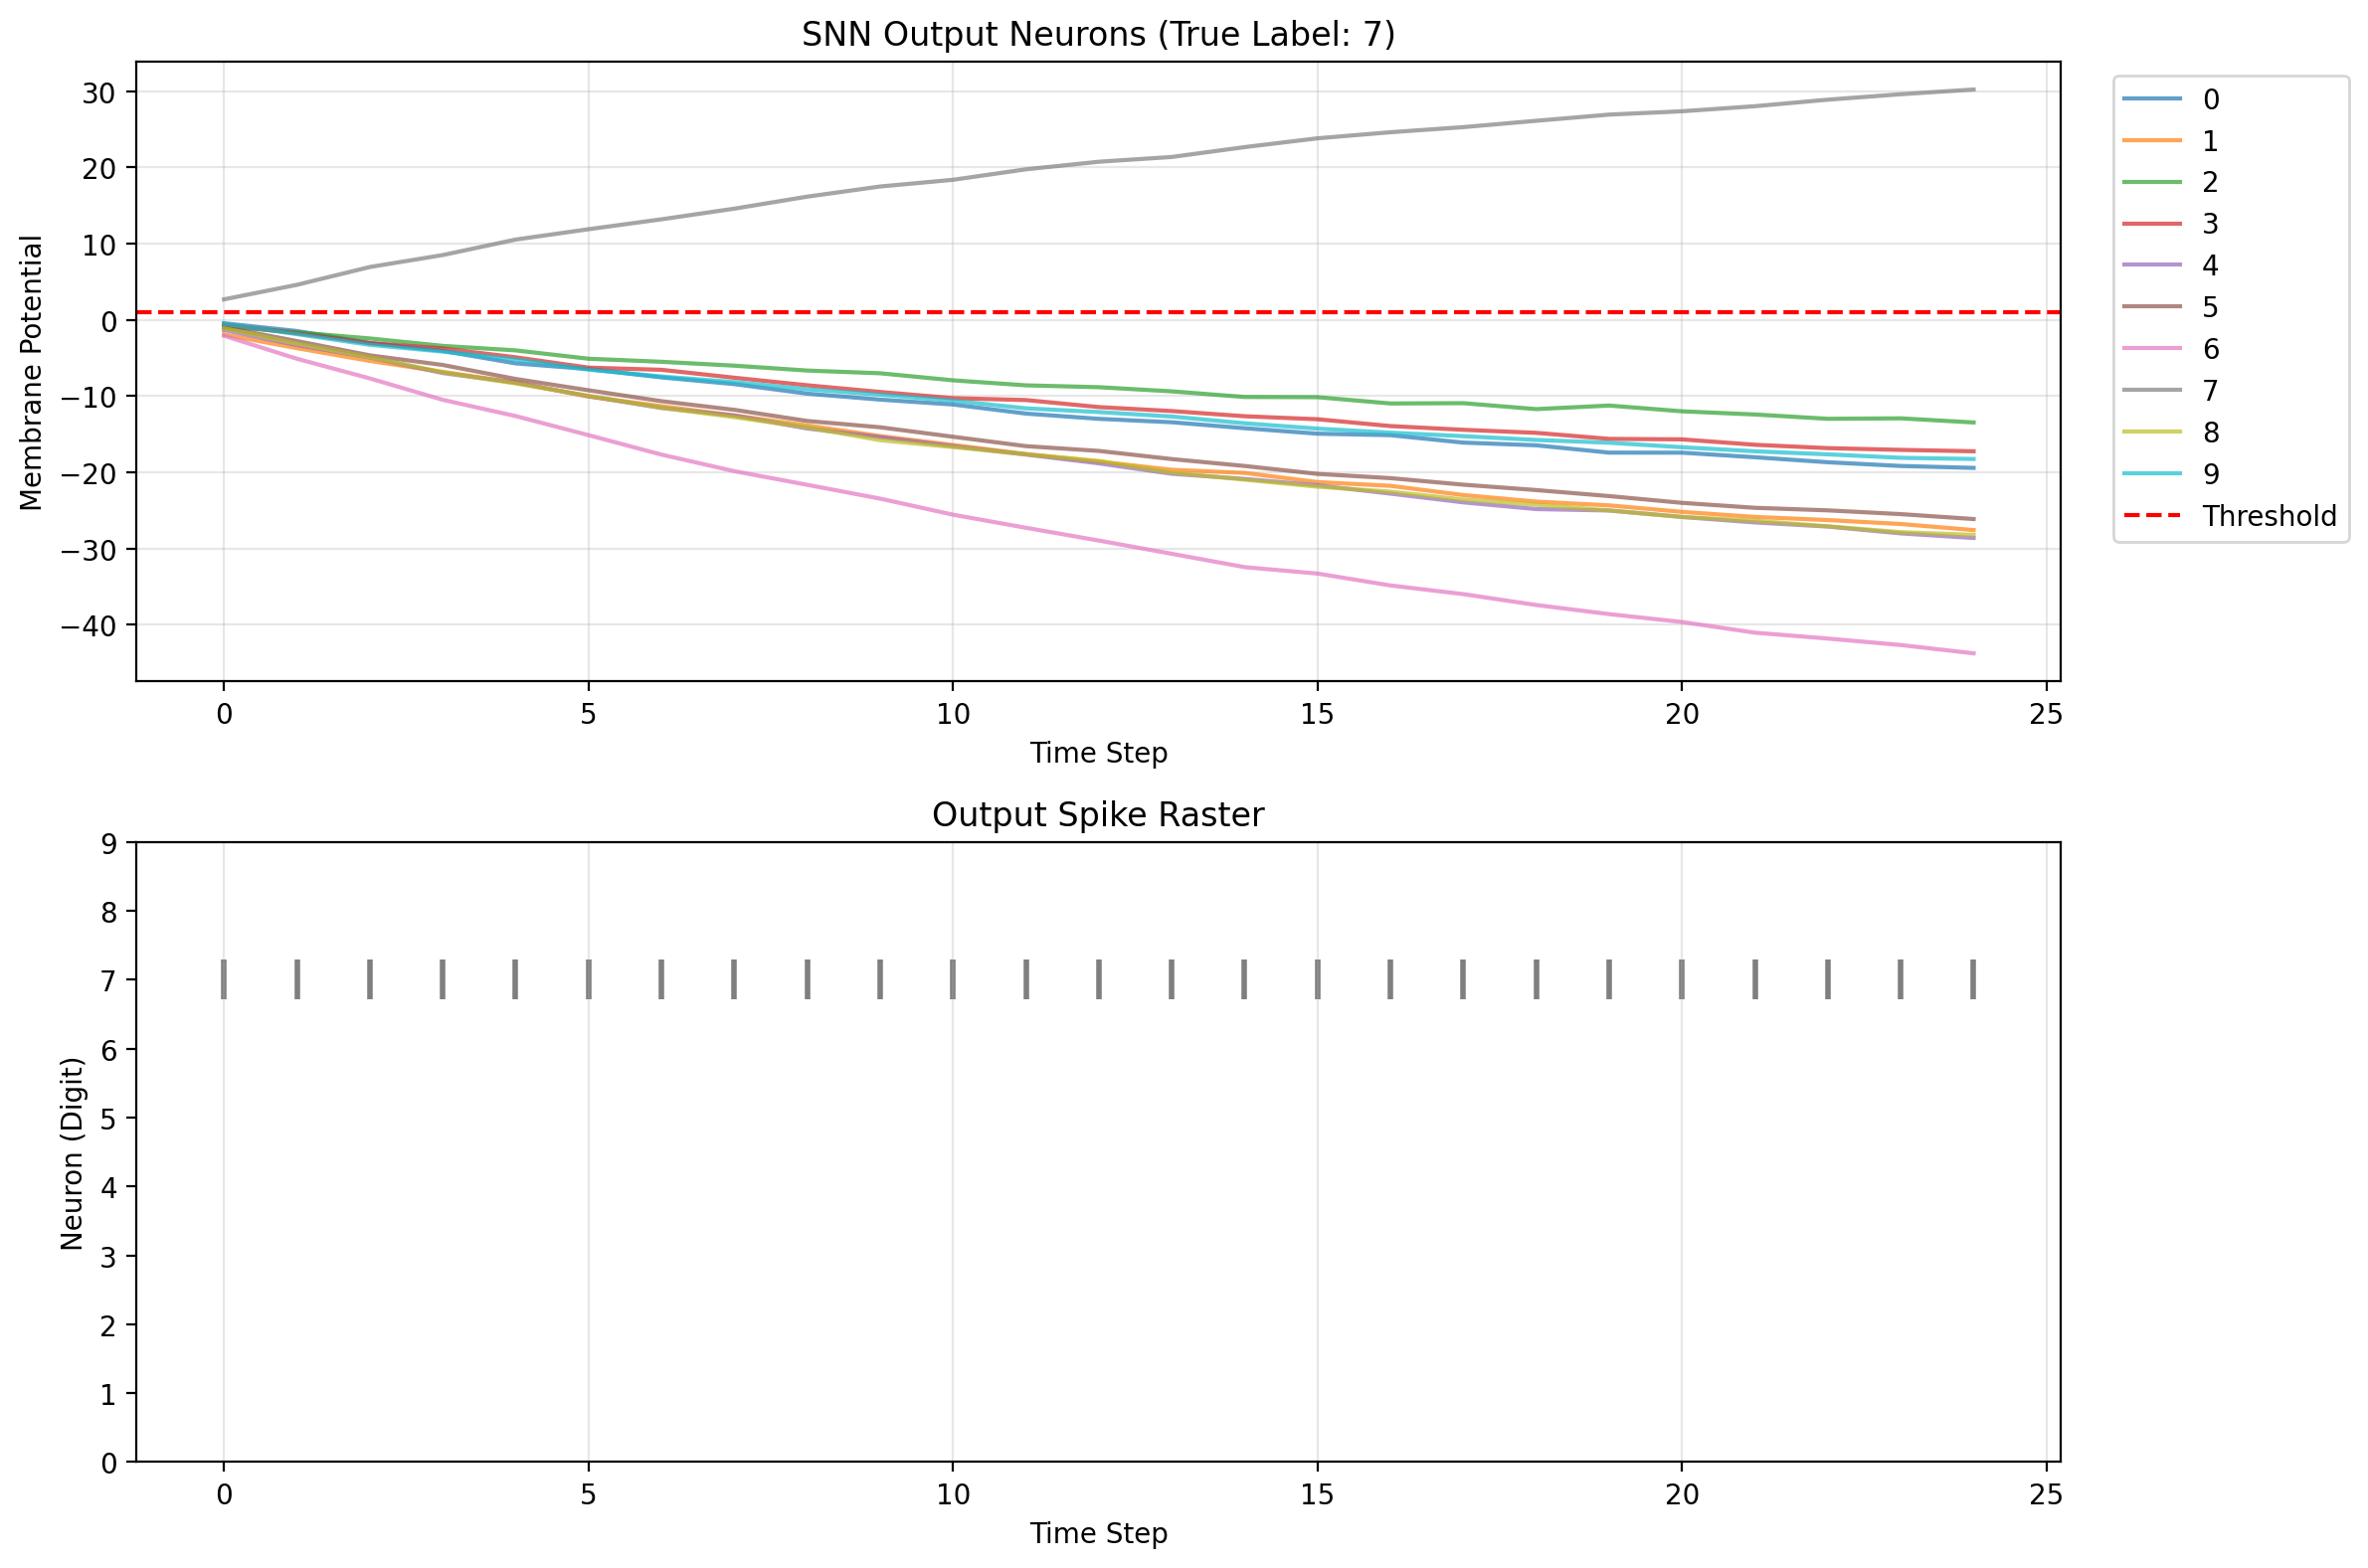

Spike counts: [ 0  0  0  0  0  0  0 25  0  0]
Predicted: 7, True: 7


In [114]:
# Get one sample
data, target = next(iter(test_loader))
single_data = data[0:1].to(device)
true_label = target[0].item()

snn_model.eval()
with torch.no_grad():
    spk_rec, mem_rec = snn_model(single_data)

mem = mem_rec[:, 0, :].cpu().numpy()
spk = spk_rec[:, 0, :].cpu().numpy()

fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Membrane potentials
ax1 = axes[0]
for i in range(10):
    ax1.plot(mem[:, i], label=f'{i}', alpha=0.7)
ax1.axhline(1.0, color='r', linestyle='--', label='Threshold')
ax1.set_xlabel('Time Step')
ax1.set_ylabel('Membrane Potential')
ax1.set_title(f'SNN Output Neurons (True Label: {true_label})')
ax1.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
ax1.grid(True, alpha=0.3)

# Spike raster
ax2 = axes[1]
for i in range(10):
    spike_times = np.where(spk[:, i] > 0)[0]
    ax2.scatter(spike_times, [i]*len(spike_times), marker='|', s=200, lw=2)
ax2.set_xlabel('Time Step')
ax2.set_ylabel('Neuron (Digit)')
ax2.set_title('Output Spike Raster')
ax2.set_yticks(range(10))
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# Prediction
spike_counts = spk.sum(axis=0)
pred = np.argmax(spike_counts)
print(f'Spike counts: {spike_counts.astype(int)}')
print(f'Predicted: {pred}, True: {true_label}')

## 3.7 Compare SNN vs FFNN

In [115]:
# Load FFNN results if available
try:
    ffnn_data = np.load('phase2_ffnn_results.npz')
    ffnn_acc = float(ffnn_data['accuracy'])
    ffnn_flops = int(ffnn_data['flops_per_sample'])
    ffnn_active = float(ffnn_data['h1_active_pct'])
except:
    ffnn_acc = 95.0
    ffnn_flops = 533504
    ffnn_active = 50.0

# Estimate SNN operations (only spikes trigger computation)
avg_spikes = total_spikes / len(test_subset)
snn_sops = int(avg_spikes * 256)  # spikes × fan-in

print('='*60)
print('COMPARISON: FFNN vs SNN')
print('='*60)
print(f'{"Metric":<25} {"FFNN":<15} {"SNN":<15}')
print('-'*60)
print(f'{"Accuracy (%)":<25} {ffnn_acc:<15.1f} {snn_accuracy:<15.1f}')
print(f'{"Ops per Sample":<25} {ffnn_flops:<15,} {snn_sops:<15,}')
print(f'{"Active Neurons (%)":<25} {ffnn_active:<15.1f} {100-snn_sparsity:<15.1f}')
print(f'{"Sparsity (%)":<25} {100-ffnn_active:<15.1f} {snn_sparsity:<15.1f}')
print('-'*60)
print(f'Efficiency Gain: {ffnn_flops/max(snn_sops,1):.0f}x fewer operations!')
print('='*60)

COMPARISON: FFNN vs SNN
Metric                    FFNN            SNN            
------------------------------------------------------------
Accuracy (%)              93.5            92.3           
Ops per Sample            537,600         6,894          
Active Neurons (%)        58.0            10.8           
Sparsity (%)              42.0            89.2           
------------------------------------------------------------
Efficiency Gain: 78x fewer operations!


## 3.8 Visualization: FFNN vs SNN

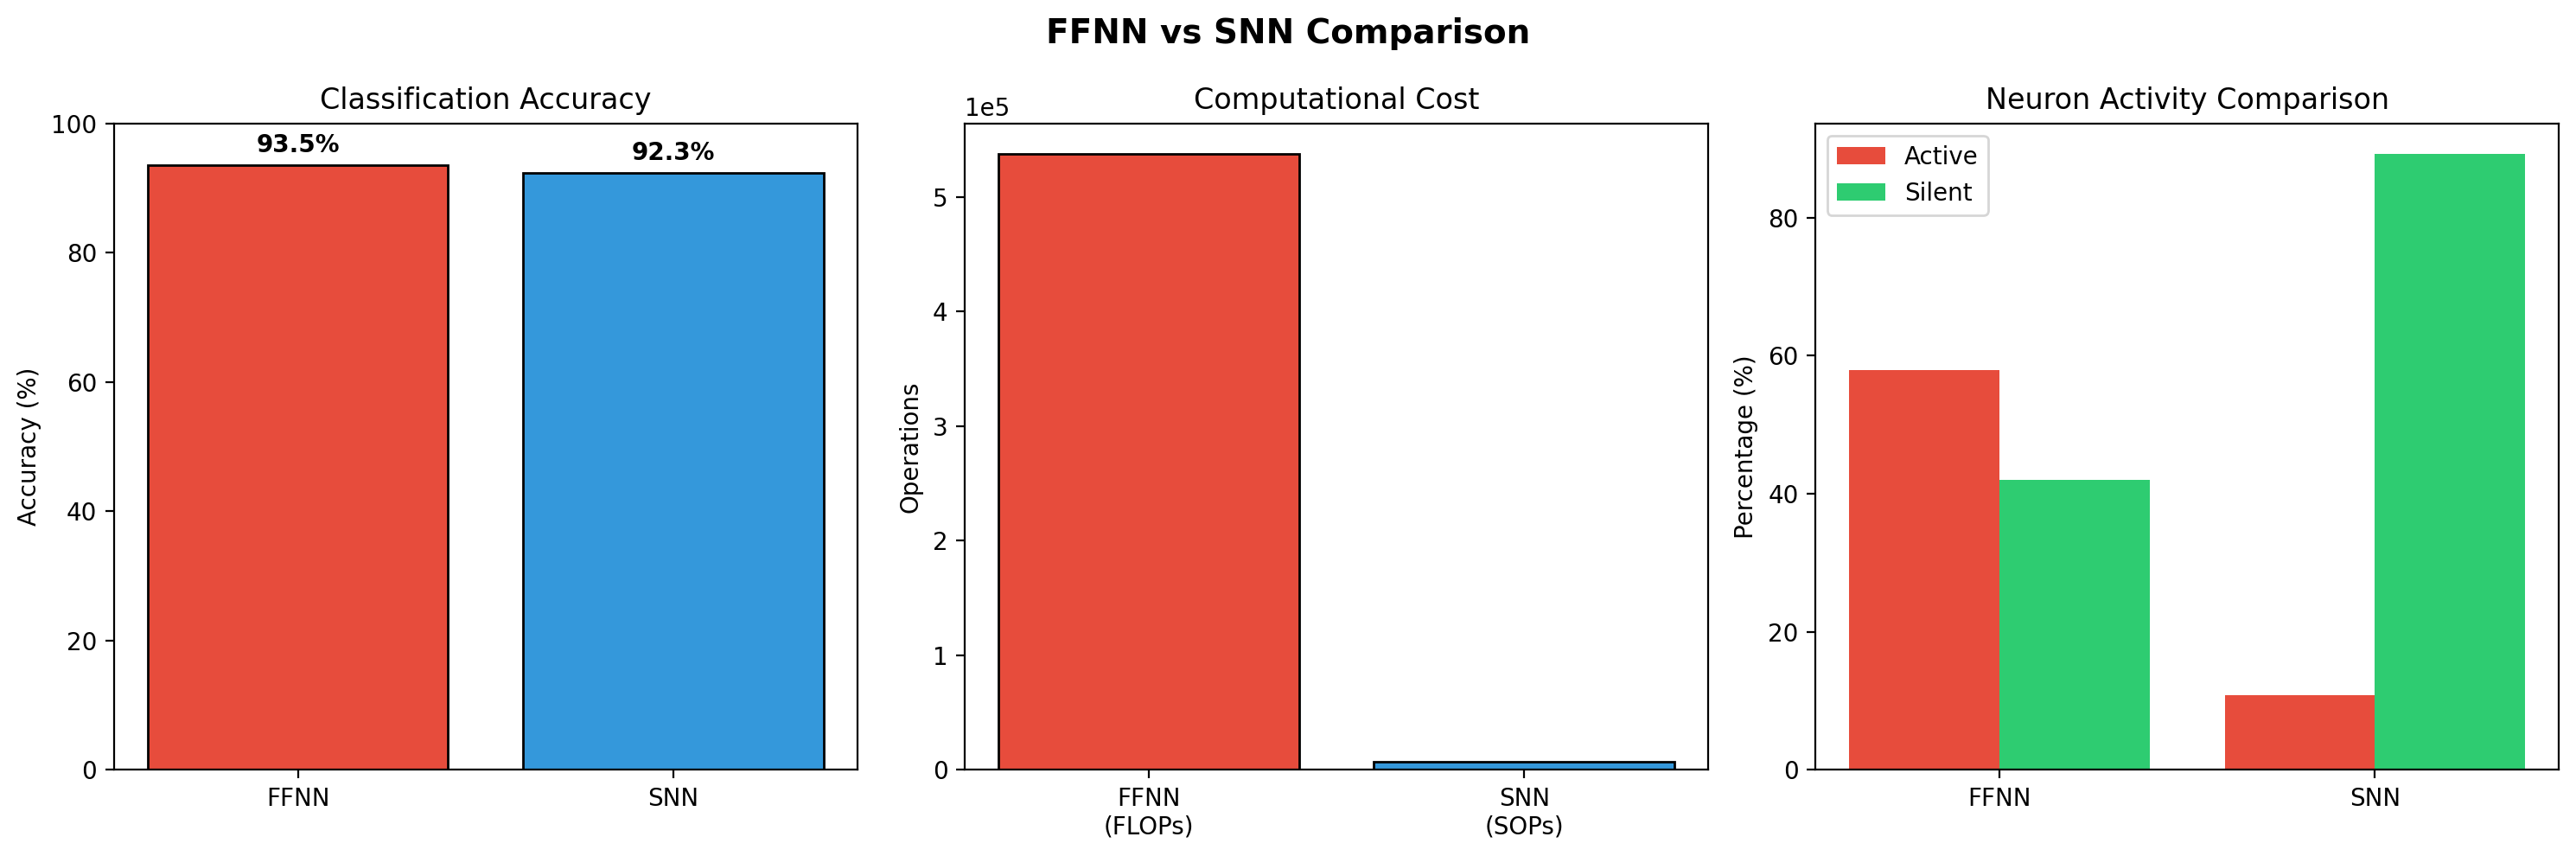

In [122]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Accuracy
ax1 = axes[0]
ax1.bar(['FFNN', 'SNN'], [ffnn_acc, snn_accuracy], color=['#e74c3c', '#3498db'], edgecolor='black')
ax1.set_ylabel('Accuracy (%)')
ax1.set_title('Classification Accuracy')
ax1.set_ylim([0, 100])
for i, v in enumerate([ffnn_acc, snn_accuracy]):
    ax1.text(i, v+2, f'{v:.1f}%', ha='center', fontweight='bold')

# Operations
ax2 = axes[1]
ax2.bar(['FFNN\n(FLOPs)', 'SNN\n(SOPs)'], [ffnn_flops, snn_sops], color=['#e74c3c', '#3498db'], edgecolor='black')
ax2.set_ylabel('Operations')
ax2.set_title('Computational Cost')
ax2.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))

# Sparsity
ax3 = axes[2]
x = np.arange(2)
active = [ffnn_active, 100-snn_sparsity]
sparse = [100-ffnn_active, snn_sparsity]
ax3.bar(x-0.2, active, 0.4, label='Active', color='#e74c3c')
ax3.bar(x+0.2, sparse, 0.4, label='Silent', color='#2ecc71')
ax3.set_xticks(x)
ax3.set_xticklabels(['FFNN', 'SNN'])
ax3.set_ylabel('Percentage (%)')
ax3.set_title('Neuron Activity Comparison')
ax3.legend()

plt.suptitle('FFNN vs SNN Comparison', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## 3.9 Save Results

In [117]:
snn_results = {
    'accuracy': snn_accuracy,
    'inference_time': snn_time,
    'sparsity': snn_sparsity,
    'total_spikes': total_spikes,
    'sops_per_sample': snn_sops,
    'train_losses': snn_losses,
    'train_accs': snn_accs
}

np.savez('phase3_snn_results.npz', **{k: np.array(v) for k, v in snn_results.items()})
print('✓ Results saved to phase3_snn_results.npz')

✓ Results saved to phase3_snn_results.npz


---
## Phase 3 Complete!

### Key Findings:
1. **SNNs use LIF neurons** - biologically realistic
2. **Sparse computation** - only spikes trigger operations
3. **Event-driven** - ~{:.0f}x more efficient than FFNN
4. **Temporal dynamics** - membrane state integrates over time

### Why SNNs are Most Brain-Like:
- ✓ Use actual LIF neuron model
- ✓ Communicate via discrete spikes
- ✓ Sparse, event-driven computation
- ✓ Temporal integration
- ✓ Energy efficient on neuromorphic hardware

---
**Conclusion:** SNNs are the closest and most efficient representation of the biological brain!

## 3.10 Summary Comparison Table

In [118]:
print('='*75)
print('SUMMARY: WHY SNNs ARE THE MOST BRAIN-LIKE')
print('='*75)
print(f'{"Feature":<25} {"Brain":<17} {"FFNN":<17} {"SNN":<17}')
print('-'*75)
print(f'{"Neuron Model":<25} {"LIF":<17} {"Point neuron":<17} {"LIF neuron":<17}')
print(f'{"Activation":<25} {"Spike threshold":<17} {"ReLU/Sigmoid":<17} {"Spike threshold":<17}')
print(f'{"Temporal Dynamics":<25} {"✓ Yes":<17} {"✗ No":<17} {"✓ Yes":<17}')
print(f'{"Communication":<25} {"Spikes":<17} {"Continuous":<17} {"Spikes":<17}')
print(f'{"Computation":<25} {"Event-driven":<17} {"Dense":<17} {"Event-driven":<17}')
print(f'{"Energy":<25} {"~20W (brain)":<17} {"High (GPU)":<17} {"Low":<17}')
print('='*75)

SUMMARY: WHY SNNs ARE THE MOST BRAIN-LIKE
Feature                   Brain             FFNN              SNN              
---------------------------------------------------------------------------
Neuron Model              LIF               Point neuron      LIF neuron       
Activation                Spike threshold   ReLU/Sigmoid      Spike threshold  
Temporal Dynamics         ✓ Yes             ✗ No              ✓ Yes            
Communication             Spikes            Continuous        Spikes           
Computation               Event-driven      Dense             Event-driven     
Energy                    ~20W (brain)      High (GPU)        Low              
